# Computer Vision PS (WS21/22)

## Exercise sheet C (ExC)

**Group members**: Ilpo Viertola, Niklas Nurminen

**Total (possible) points**: 8

---

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np

import torch
import torch.nn as nn
from torch.optim import SGD

## ExC.1 (8 points)

In this exercise, we are given $N$ points on a 1-sphere

$$\mathbb{S}^1 = \{\mathbf{x} \in \mathbb{R}^2: \| \mathbf{x} \|=1\}\enspace,$$

i.e., a circle. We define an **energy** for these points as

$$ E_2(\mathbf{x}_1,\ldots,\mathbf{x}_N) = \sum_{i=1}^N\sum_{j=1}^N \mathbf{1}_{i\neq j} \frac{1}{\|\mathbf{x}_i - \mathbf{x}_j \|^2} $$

where $\mathbf{1}_{i\neq j}=1$ if $i \neq j$ and 0 else. Our goal is to find the configuration of the $N$ points $\mathbf{x}_1,\ldots,\mathbf{x}_N$ such that $E_2$ is **minimized**. 

We will do this by using PyTorch's SGD optimizer (i.e., Stochastic Gradient Descent) which we abuse for classic gradient descent. In our example, the points take the role of the *model parameters*. So, any gradient descent update will modify the point positions. In other words, after assembling all our $N$ points into a $N \times 2$ matrix $\mathbf{X}$, we compute

$$ \frac{\partial E_2(\mathbf{X})}{\partial \mathbf{X}}$$

(via automatic differentiation) and update $\mathbf{X}$ as

$$ \mathbf{X}^{(t+1)} = \mathbf{X}^{(t)} - \alpha  \frac{\partial E_2(\mathbf{X})}{\partial \mathbf{X}}$$

with $\mathbf{X}^{(0)} = \mathbf{X}$ and *learning rate $\alpha>0$.

### Creating our data

Lets first create some points by drawing $N=10$ iid samples from $\mathcal{N}(\mathbf{0},\mathbf{I})$ and projecting them onto $\mathbb{S}^1$ by dividing each sample by its norm. The helper routine `normalize` already does this for your.

In [2]:
def normalize(x): 
    x = x / torch.norm(x, dim=1, p=2, keepdim=True)
    return x

torch.manual_seed(1234)
X = torch.randn(10,2)
X = normalize(X)

Lets visualize what we've got at this point.

In [3]:
def viz(points, draw_circle=False, draw_lines=False, title=None):
    fig, ax = plt.subplots()
    if draw_circle:
        circ = plt.Circle((0, 0), 1.0, color='r', fill=False, linewidth=1)
        ax.add_patch(circ)
    ax.plot(points[:,0], 
            points[:,1],'.', color='black',markersize=7)
    if draw_lines:
        for i in range(points.size(0)):
            plt.plot([0,points[i,0]], 
                     [0,points[i,1]], 
                     marker = 'o', 
                     color='black',
                     linewidth=1)    
    ax.set_aspect('equal', 'box')
    if title is not None:
        ax.set_title(title)

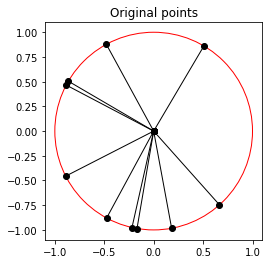

In [4]:
viz(X,True,True,'Original points')

### Optimization

Now comes the interesting part. The following cell already contains some helper code upon which you can build your solution. In particular, implement the following steps

1. zero gradients (using `opt.zero_grad()`)
2. implement computation of the energy function $E_2$ from above
3. perform a backward step (i.e., computing the gradients)
4. take an optimizer step
5. project back to S^1

and iterate this part for, say 300 iterations at a learning rate of $0.01$ (but you can try other choices).

**Importantly**, step (5) needs to be computed on `points.data` not to confuse the computation graph. To track progress throughout the update steps, I do recommend to append, after each update step, a clone of the current point configuration to a list `points_tracker`, e.g., via `points_tracker.append(torch.clone(points.data))`. 

As for setting the learning rate, try $0.01$.

In [5]:
points = torch.clone(X)              # clone the original data matrix
points = normalize(points)           # project points onto S^1 
points = nn.Parameter(points)  # make points a torch.nn.Parameter for use in optimizer

points_tracker = []                  # e.g., in case you want to track the point positions after each update


iterations = 300
lr = .01
opt = SGD([points], lr=lr)

print("Initial:", points.detach().numpy())

for _ in range(iterations):
    points_tracker.append(torch.clone(points.data))
    
    opt.zero_grad()

    # TODO: Make energy evaluation better
    E_2 = 0
    for i in range(points.size()[0]):
        for j in range(points.size()[0]):
            if i != j:
                E_2 += 1 / (points[i] - points[j]).norm().pow(2)
            else:
                E_2 += 0

    E_2.backward()
    opt.step()
    points = nn.Parameter(normalize(points.data))

print("Result:", points.detach().numpy())

Initial: [[-0.21948563 -0.97561574]
 [ 0.18187164 -0.98332226]
 [ 0.5082446   0.8612128 ]
 [-0.47589082 -0.8795044 ]
 [ 0.66563255 -0.74627966]
 [-0.890059   -0.45584542]
 [-0.8849978   0.4655953 ]
 [-0.47880414  0.87792176]
 [-0.86325735  0.50476414]
 [-0.1685689  -0.9856899 ]]
Result: [[-0.9819944   0.1889102 ]
 [ 0.8213971  -0.5703567 ]
 [ 0.5455244   0.8380949 ]
 [-0.99997026  0.00771208]
 [ 0.8607741  -0.50898725]
 [-0.9581833  -0.28615528]
 [-0.4875126  -0.87311596]
 [-0.1512612   0.98849386]
 [ 0.48305583  0.87558955]
 [ 0.9800068  -0.19896407]]


If you kept track of the points after each update step (in the list `points_tracker`), you could visualize the progress, e.g., via

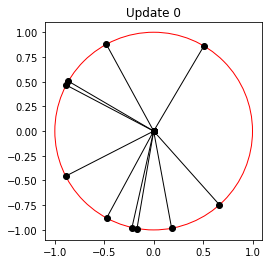

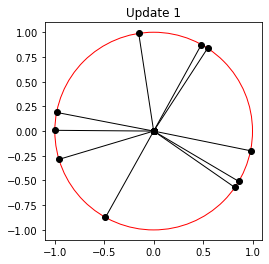

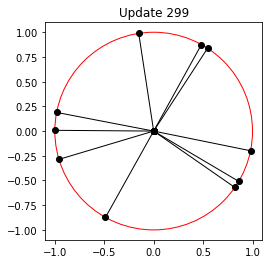

In [6]:
viz(points_tracker[0],True,True,'Update {}'.format('0'))
viz(points_tracker[1],True,True,'Update {}'.format('1'))
viz(points_tracker[-1],True,True,'Update {}'.format('299'))

You can play around with different settings for $N$. For instance, take $N=3$ just for fun!